In [1]:
from __future__ import division

import gzip
import os

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn

from scipy.linalg import svdvals

import theano
import theano.tensor as T

import seaborn as sns

Couldn't import dot_parser, loading of dot files will not be possible.


/Users/matsuik/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
sns.set_style("darkgrid")

In [3]:
x = T.matrix("x") # (N, dim)
y = T.matrix("y") # (N, dim)
W = theano.shared(np.zeros((2, 2)),
                 borrow=True) # (dim, dim)
y = T.dot(x, W)

t = T.matrix("t") # (N, dim)
 
E = T.sum((t - y)**2)

d_W = T.grad(cost=E, wrt=W)

lr = T.scalar("lr")
update_list = [(W, W - lr * d_W)]

f_train = theano.function(inputs=[x, t, lr],
                    updates=update_list)
f_error = theano.function(inputs=[x, t],
                          outputs=[E])

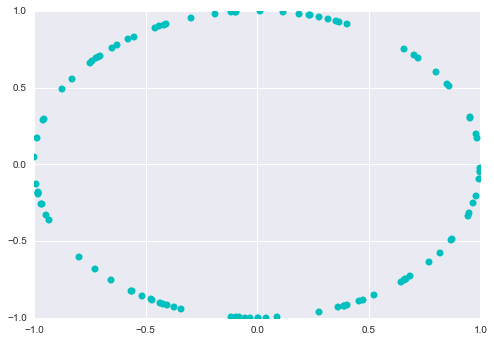

In [30]:
rg = np.random.RandomState(seed=1999)
all_data = rg.normal(size=(100, 2))
all_data = all_data / np.linalg.norm(all_data, axis=1)[:, np.newaxis]
plt.plot(all_data[:, 0], all_data[:, 1], "co")

In [31]:
def R(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

R(np.pi / 3)

array([[ 0.5      , -0.8660254],
       [ 0.8660254,  0.5      ]])

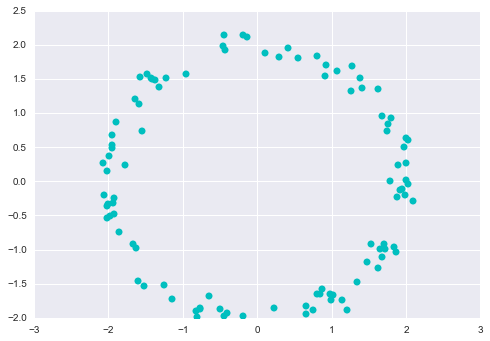

In [32]:
all_target = 2. * np.dot(all_data, R(np.pi / 3).T) + 0.1 * rg.normal(size=all_data.shape)
plt.plot(all_target[:, 0], all_target[:, 1], "co")

In [33]:
def clcl_cn_inv(mat):
    """
    Calculate inverse conditional number of 2D matrix.
    
    Param
    --------
    mat : ndarray
        (2, 2)
    
    Ret
    ----
    cn_inv : float
    """
    sv = svdvals(mat)
    cn_inv = sv[1] / sv[0]
    
    return cn_inv

# test
print clcl_cn_inv(np.ones((2, 2))), clcl_cn_inv(np.zeros((2, 2))), clcl_cn_inv(np.eye(2)), clcl_cn_inv(R(np.pi / 3))

0.0 nan 1.0 1.0


In [34]:
def visualize(N, error_list, test_error_list, cn_inv_list):
    plt.figure()
    plt.plot(error_list)
    plt.title("N=" + str(N) + " error")
    print "last error", error_list[-1]

    plt.figure()
    plt.plot(test_error_list)
    plt.title("N=" + str(N) + "test_error")
    print "last error", test_error_list[-1]

    plt.figure()
    plt.plot(cn_inv_list)
    plt.ylim(0., 1.)
    plt.title("N=" + str(N) + " cn_inv")
    print "last cn_inv", cn_inv_list[-1]

early stop at epoch 73
last error 0.0174929974431
last error 0.221536365547
last cn_inv 0.979740553866
early stop at epoch 70


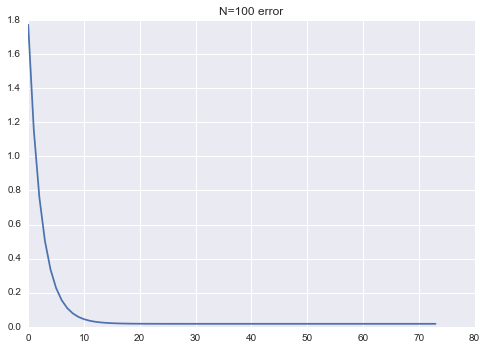

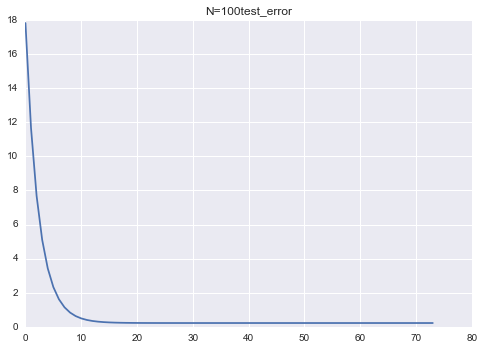

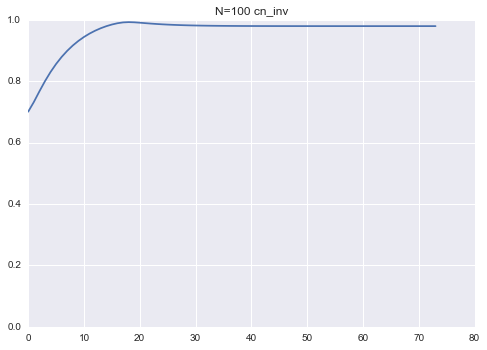

In [35]:
def ex_condnum_linear(N, 
                      lr, n_epochs,
                      max_patience, thresh,
                      to_visualize):
    """
    Parameters
    ---------------
    N : int
        
    lr : float
    n_epochs : int
    
    max_patience : int
    thresh : float
    
    to_visualize : bool
    
    Returns
    ----------
    if to_visualize:
        None
    else:
        error : float
        cn_inv : float
    """
    W.set_value(rg.normal(size=(2, 2)), borrow=True)
    
    interval = 100 // N

    # サンプルは毎回ランダム
    index = rg.choice(range(all_data.shape[0]), size=(N, ))
    input = all_data[index]
    target = all_target[index]
    
    if to_visualize:
        error_list = []
        test_error_list = []
        cn_inv_list = []
        
    patience = 0
    old = 1.
    for i_epoch in range(n_epochs):
        f_train(input, target, lr)
        
        # interval ごとに , early stopping用のcn_invと、plotするためのerror, test_errorを計算
        if i_epoch % interval == 0:
            cn_inv = clcl_cn_inv(W.get_value(borrow=True))
        
            if to_visualize:
                error = f_error(input, target)[0]
                test_error = f_error(all_data, all_target)[0]
                
                error_list.append(error / N)
                test_error_list.append(test_error / 10)
                cn_inv_list.append(cn_inv)
        
        # evaluate early stopping
        if abs(cn_inv - old) < thresh:
            patience += N
            if patience > max_patience: # when early stop
                print "early stop at epoch", str(i_epoch)
                if to_visualize:
                    visualize(N, error_list, test_error_list, cn_inv_list)
                    break
                else:
                    error = f_error(input, target)[0]
                    test_error = f_error(all_data, all_target)[0]
                    return error, test_error, cn_inv
        else:
            patience = 0
        
        old = cn_inv
        
    else: # early stop せずに出てきたとき
        if to_visualize:
            visualize(N, error_list, test_error_list, cn_inv_list)
        else:
            error = f_error(input, target)[0]
            test_error = f_error(all_data, all_target)[0]
            return error, test_error, cn_inv
    
# test :   
ex_condnum_linear(
    N = 100,
    lr=0.002, n_epochs=100,
    max_patience=1000, thresh=0.000001,
    to_visualize=True)

error, test_error, cn_inv = ex_condnum_linear(
    N = 100,
    lr=0.002, n_epochs=100,
    max_patience=1000, thresh=0.000001,
    to_visualize=False)

1
early stop at epoch 3801
last error 2.63338032996e-13
last error 15.5519936258
last cn_inv 0.10965305268
3
early stop at epoch 5614
last error 0.00957203411041
last error 0.345278212869
last cn_inv 0.918634340226
5
early stop at epoch 2261
last error 0.0214544221622
last error 0.23392868938
last cn_inv 0.970965035461
10
early stop at epoch 1061
last error 0.00976968799221
last error 0.261966113026
last cn_inv 0.926596821322
20
early stop at epoch 361
last error 0.0202680858323
last error 0.242432152289
last cn_inv 0.97572761044
50
early stop at epoch 161
last error 0.0214241757302
last error 0.230811096148
last cn_inv 0.986231399806
100
early stop at epoch 68
last error 0.0179752649749
last error 0.227642394044
last cn_inv 0.984417341806


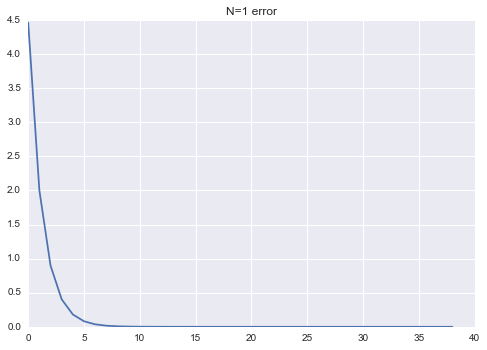

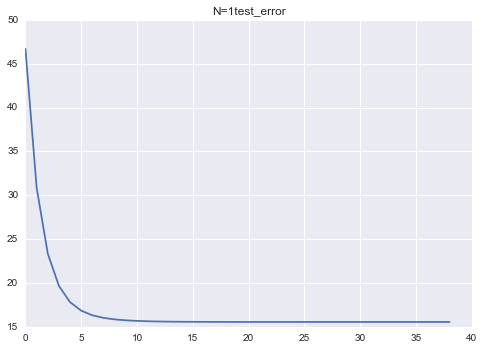

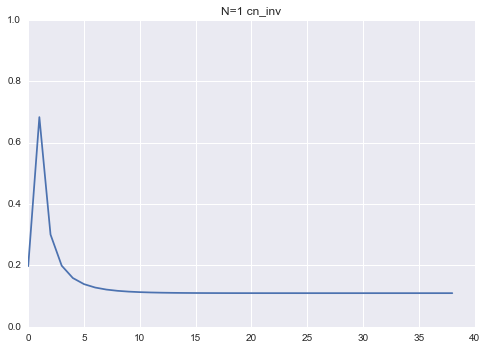

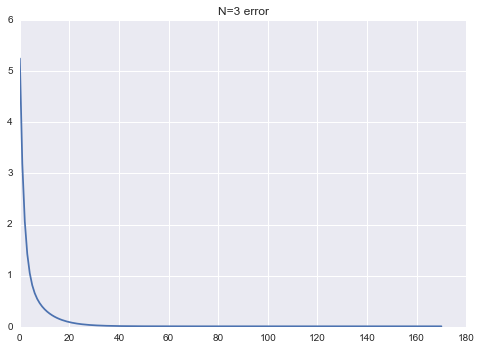

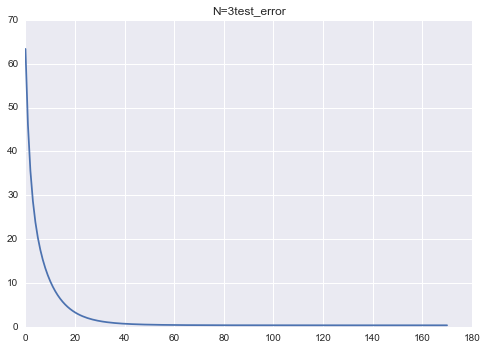

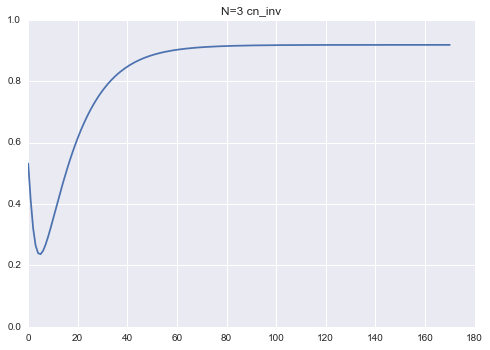

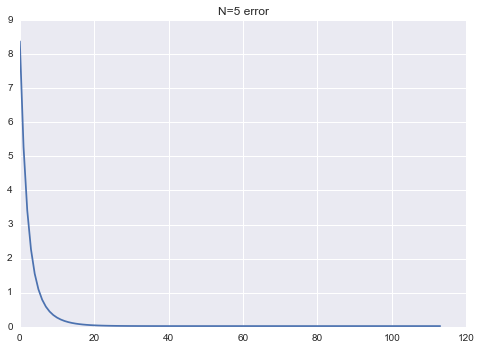

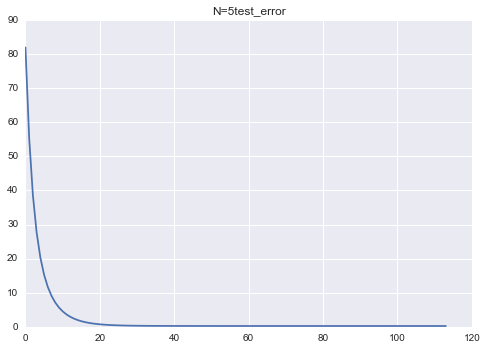

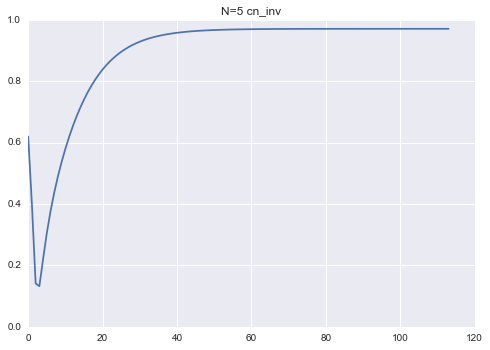

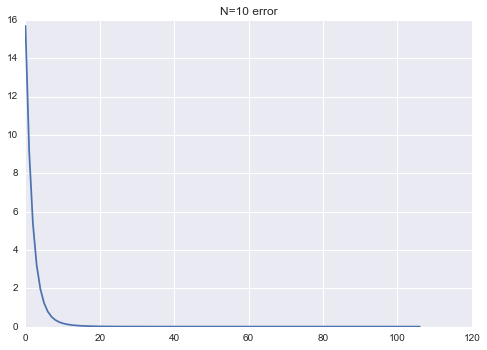

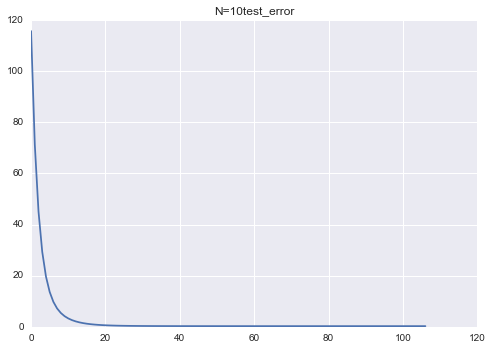

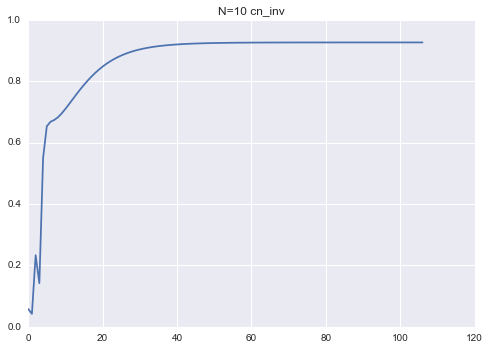

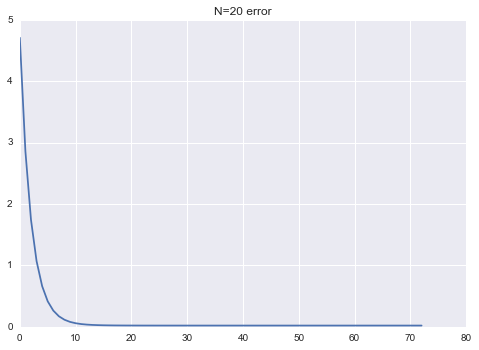

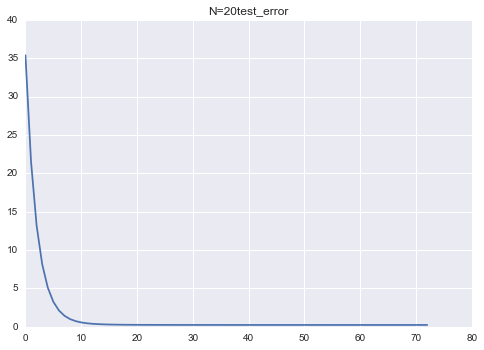

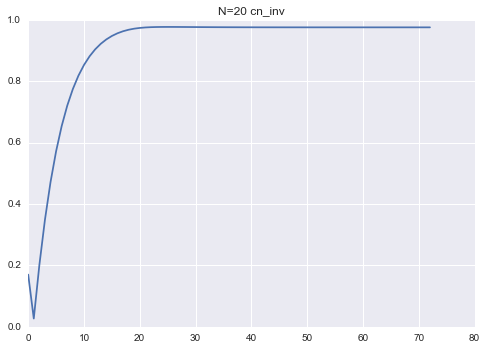

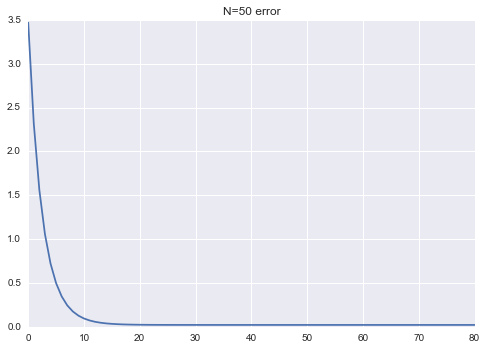

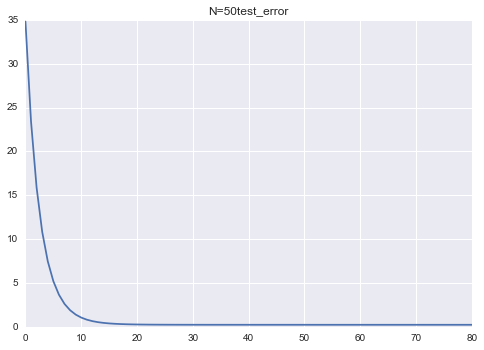

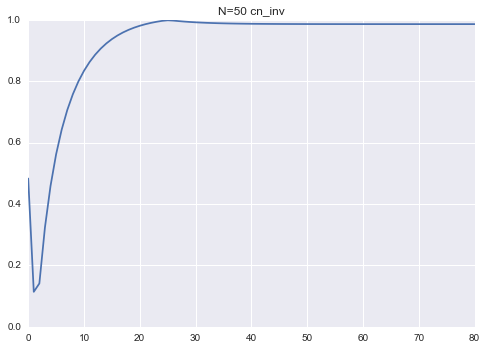

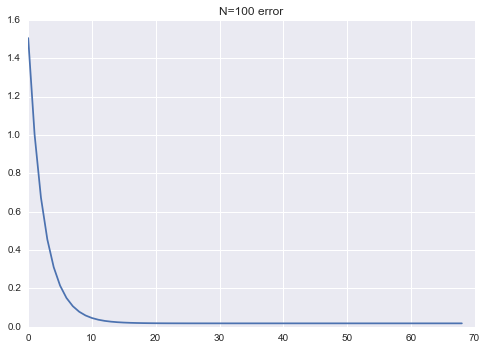

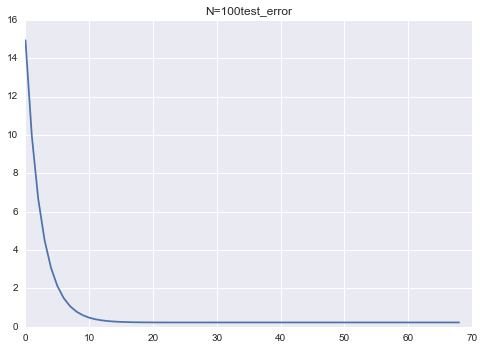

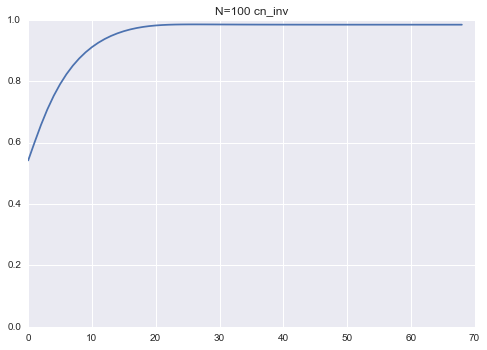

In [36]:
# visualize
for N in [1, 3, 5, 10, 20, 50, 100]:
    print N
    ex_condnum_linear(
        N,
        lr=0.002, n_epochs=30000,
        max_patience=1000, thresh=0.000001,
        to_visualize=True)

In [37]:
to_reclcl = True
N_list = [1, 2, 3, 5, 8, 10, 15, 20, 30, 50, 100]
if (not os.path.exists("../results/CondNumLinear/N_cn_list.npy.gz")) or to_reclcl:
    
    N_cn_list = []
    N_test_error_list = []
    for N in N_list:
        print "N=", N
        cn_list = []
        test_error_list = []
        for i_episode in range(30):
            print i_episode
            error, test_error, cn = ex_condnum_linear(
                N,
                lr=0.002, n_epochs=30000,
                max_patience=1000, thresh=0.000001,
                to_visualize=False)
            cn_list.append(cn)
            test_error_list.append(test_error)
        N_cn_list.append(cn_list)
        N_test_error_list.append(test_error_list)
        if not os.path.exists("../results/CondNumLinear"):
            os.makedirs("../results/CondNumLinear")
        with gzip.open("../results/CondNumLinear/N_cn_list.npy.gz", "w") as f:
            np.save(f, np.asarray(N_cn_list))
        with gzip.open("../results/CondNumLinear/N_test_error_list.npy.gz", "w") as f:
            np.save(f, np.asarray(N_test_error_list))
else:
    with gzip.open("../results/CondNumLinear/N_cn_list.npy.gz", "r") as f:
        N_cn_list = np.load(f)
    with gzip.open("../results/CondNumLinear/N_test_error_list.npy.gz", "r") as f:
        N_test_error_list = np.load(f)

N= 1
0
early stop at epoch 3601
1
early stop at epoch 4001
2
early stop at epoch 4101
3
early stop at epoch 3601
4
early stop at epoch 3901
5
early stop at epoch 3801
6
early stop at epoch 3801
7
early stop at epoch 3501
8
early stop at epoch 4001
9
early stop at epoch 4101
10
early stop at epoch 3401
11
early stop at epoch 4001
12
early stop at epoch 3601
13
early stop at epoch 4101
14
early stop at epoch 3501
15
early stop at epoch 3601
16
early stop at epoch 3901
17
early stop at epoch 3801
18
early stop at epoch 4001
19
early stop at epoch 3201
20
early stop at epoch 3601
21
early stop at epoch 3601
22
early stop at epoch 3801
23
early stop at epoch 3801
24
early stop at epoch 4201
25
early stop at epoch 3301
26
early stop at epoch 2601
27
early stop at epoch 4001
28
early stop at epoch 4001
29
early stop at epoch 3501
N= 2
0
early stop at epoch 6801
1
2
3
early stop at epoch 8151
4
early stop at epoch 17601
5
early stop at epoch 4551
6
early stop at epoch 5051
7
early stop at epoc

(0.0, 1.0)

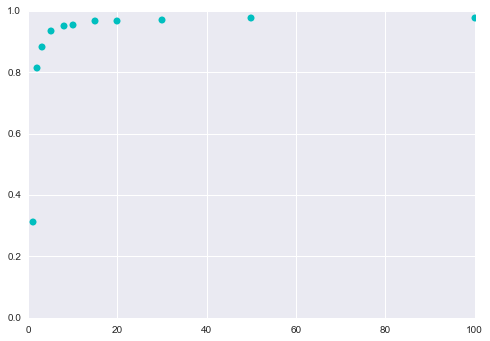

In [38]:
plt.plot(N_list, np.mean(N_cn_list, axis=1), "co")
plt.ylim(0., 1.)

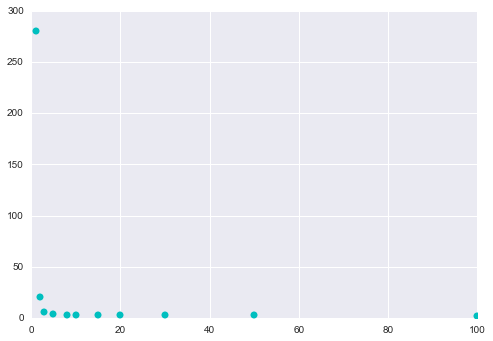

In [39]:
plt.plot(N_list, np.mean(N_test_error_list, axis=1), "co")

In [28]:
gomi = plt.hist(N_cn_list[0])